# INSTRUCTIONS

#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from matplotlib import pyplot as plt

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json

# open output file for reading
with open('optimals_newest_Monaco-2020-12-02-191804.txt', 'r') as filehandle:
    racing_track = json.load(filehandle)
#    print(basicList)
print(len(racing_track))

234


In [3]:
TRACK_NAME = "Monaco"
# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))


In [4]:

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.6
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))


In [5]:
newol = [outer_border_new[27], inner_border_new[55], outer_border_new[98], inner_border_new[133], outer_border_new[157]]
#newol = [outer_border_new[27], inner_border_new[55], outer_border_new[98], inner_border_new[133], outer_border_new[157], inner_border_new[227]]
newol

[array([-1.0813154 ,  2.40199916]),
 array([3.58564939, 5.06562262]),
 array([6.65463181, 2.32572694]),
 array([ 3.66050162, -1.02537804]),
 array([-1.83536141, -1.32714171])]

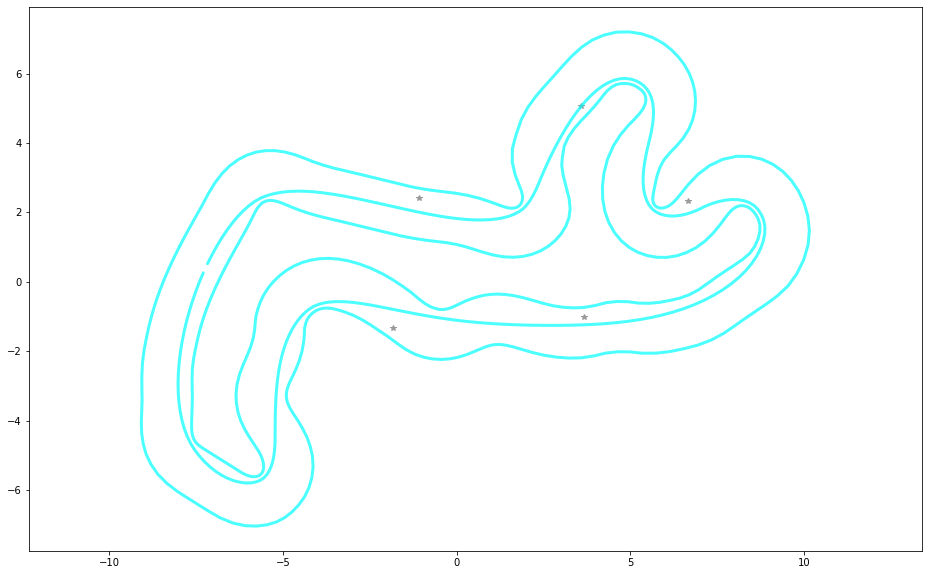

In [6]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '*', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def plot_line2(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                     
    
def print_border2(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    #plot_coords(ax, line)                                                       
    #plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')
print_border2(ax, center_line, inner_border, outer_border)

# Also print new border
#print_border(ax, center_line, inner_border_new, outer_border_new)

plot_line(ax, LineString(np.asarray(racing_track)[:,0:2]))
#plot_line2(ax, LineString(np.asarray(racing_track)))


plot_coords(ax, LineString(newol))
#plot_coords(ax, LineString(o2))
#plot_coords(ax, LineString(o3))
#plot_points(ax, np.asarray(center_line))


In [7]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    racing_track[i][2],
                                    racing_track[i][3],
                                    center_line[i][0],
                                    center_line[i][0],
                                    inner_border_new[i][0],
                                    inner_border_new[i][1],
                                    outer_border_new[i][0],
                                    outer_border_new[i][1]
                                   ]
                                  )
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()
print(racing_track_everything)

[[-7.17591, 0.52298, 3.49017, 0.0829, -7.3288, -7.3288, -6.94494, 0.50357, -7.71265, 0.90991], [-7.04789, 0.7761, 3.16465, 0.08963, -7.17418, -7.17418, -6.7936, 0.78962, -7.55477, 1.20809], [-6.91386, 1.01896, 2.8488, 0.09737, -7.01496, -7.01496, -6.63701, 1.07452, -7.3929, 1.50244], [-6.77416, 1.25075, 2.50403, 0.10808, -6.85213, -6.85213, -6.47296, 1.36432, -7.2313, 1.78788], [-6.62874, 1.46985, 2.20418, 0.11931, -6.69096, -6.69096, -6.30683, 1.662, -7.0751, 2.06729], [-6.47767, 1.6749, 1.93961, 0.13131, -6.54905, -6.54905, -6.18589, 1.89314, -6.91221, 2.37411], [-6.3209, 1.86422, 1.93961, 0.12673, -6.42023, -6.42023, -6.09133, 2.07174, -6.74913, 2.64979], [-6.15828, 2.036, 1.93961, 0.12195, -6.28247, -6.28247, -5.99585, 2.2319, -6.5691, 2.89526], [-5.98952, 2.18824, 1.93961, 0.11718, -6.13542, -6.13542, -5.89728, 2.36745, -6.37355, 3.10075], [-5.81384, 2.31795, 1.93961, 0.11259, -5.97788, -5.97788, -5.79185, 2.47577, -6.16391, 3.26188], [-5.62991, 2.42181, 1.93961, 0.1089, -5.81035,

In [8]:
from datetime import datetime

now = datetime.now()
prefix = '%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))

# Write to txt file
with open(f'optimals_for_OA_{prefix}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")
    print(f)

<_io.TextIOWrapper name='optimals_for_OA_Monaco-2020-12-03-184157.txt' mode='w' encoding='UTF-8'>


In [9]:
import math
import json

# open output file for reading
with open('optimals_for_OA_Monaco-2020-12-02-222751.txt', 'r') as filehandle:
    oa_racing_track = json.load(filehandle)
#    print(basicList)
print(len(oa_racing_track))

234


In [10]:


o1 = [[-0.9305498412456339, 2.3051788068776062], [5.399832815944913, 3.104284174765702], [8.280002086529988, 0.23923803569347463], [-4.713253533598179, -4.476735443873611], [-7.950431461871854, -2.291442843326418], [-8.126428022680763, -0.1620472316206611]]
o2 = [[-2.1153138802432125, 1.8160167619673613], [2.718974367693935, 3.094191020462276], [8.174953489154456, 0.16776473219667581], [3.9809893369674683, -1.0426595509052277], [0.8595635843877878, -0.7425004210392467], [-7.909992495634366, -4.644495193936562]]
o3 = [[-2.6194274021001984, 2.68579989819489], [4.778987375069798, 1.7566788064322953], [6.39663531127952, -0.8447661266540276], [4.408292839007304, -1.6749506330925614], [-2.3074679847013195, -0.08557719899903832], [-7.028792931289656, -6.249249194632359]]
o4 = [[-5.574565204895726, 3.405997408219287], [-2.1374467178790506, 2.5670382838495476], [8.949872186713627, 3.0555026516531143], [1.8909664297540774, -0.8229302472704961], [-8.70168616656893, -3.179981279592988], [-7.63826415530781, -0.9310726330007029]]
o5 = [[-2.0144717154513905, 1.7912805838431458], [2.715659302284803, 3.1074760364868252], [5.747983684367263, 1.071643430090489], [9.602943246429202, 0.6550952457486463], [-5.1925239035057125, -2.8975457038984405], [-7.691212643061788, -1.1047994731342634]]
o6 = [[2.2224397579969795, 2.4413621231264204], [6.636140628593448, 2.194698623213558], [8.628855228424072, 2.416707754135132], [-0.5649714265462619, -1.1428686641219392], [-3.931066882203001, -0.4188390120911268], [-7.8919423915339175, -1.9362760482982397]]
o7 = [[0.4814889982367836, 2.077884315481076], [4.435441209197361, 5.995586420832673], [6.739428555863852, -1.5024813964707762], [1.1208485520240274, -0.716576281864423], [-5.697766932058165, -2.255076054630529], [-8.471180621870259, -1.2104134195949965]]
o8 = [[-4.024127534170848, 3.0428563379571183], [5.796018210931006, 5.130560113369234], [5.401798963546753, 3.1142547726631165], [-5.266320858764739, -3.247209663470102], [-5.248357804466667, -5.495060053354274], [-7.990723740530145, -4.273559305390448]]


In [11]:

def dist_2_points(x1, x2, y1, y2):
    return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def indexes_cyclical(point, diff, array_len):
    next_point = point + diff
    if point + diff >= array_len:
        next_point = point + diff - array_len
    elif point + diff < 0:
        next_point = point + diff + array_len
    return next_point

def indexes_diff_cyclical(point1, point2, array_len):
    diff = point2 - point1
    #print('indexes_diff_cyclical ', point1, point2, array_len)
    #print('diff1 ', diff)
    if diff < 0:
        diff = array_len + diff
        #print('diff2 ', diff)
    if diff > array_len * 0.3:
        diff = array_len - diff
        #print('diff3 ', diff)
    return diff


In [12]:

center_line = []
inner_border_new = []
outer_border_new = []
racing_track = []

for i in range(len(oa_racing_track)):
    racing_track.append([oa_racing_track[i][0], oa_racing_track[i][1], oa_racing_track[i][2], oa_racing_track[i][3]])
    center_line.append([oa_racing_track[i][4], oa_racing_track[i][5]])
    inner_border_new.append([oa_racing_track[i][6], oa_racing_track[i][7]])
    outer_border_new.append([oa_racing_track[i][8], oa_racing_track[i][9]])

#print(inner_border_new)
#print(outer_border_new)


In [13]:
#racing_track = np.asarray(racing_track)

objects_location = newol
track_width = 1.429430688666655
track_length = 60.26571885716431

max_step = len(racing_track)
step_length = track_length / max_step

track_width_half = track_width / 2
object_lookahead = 5
object_threshold = object_lookahead * track_width_half
object_threshold_step_number = int(object_threshold / step_length)

print('max_step', max_step)
print('step_length', step_length)

print('track_width_half', track_width_half)
print('object_threshold', object_threshold)
print('object_threshold_step_number', object_threshold_step_number)

objects_waypoint_index = []
objects_lookahead_waypoint_index1 = []
objects_lookahead_waypoint_index2 = []

#print(indexes_cyclical(1,-2,100))
#print(indexes_diff_cyclical(20,19,100))

for i in range(len(objects_location)):
    distances = []
    for j in range(len(racing_track)):
        distance = dist_2_points(x1=racing_track[j][0], x2=objects_location[i][0],
                             y1=racing_track[j][1], y2=objects_location[i][1])
        distances.append(distance)
    obstacle_index = distances.index(min(distances))
    objects_waypoint_index.append(obstacle_index)
    objects_lookahead_waypoint_index1.append(indexes_cyclical(obstacle_index, -1 * object_threshold_step_number, len(racing_track)))
    objects_lookahead_waypoint_index2.append(-1)
print('objects_waypoint_index',objects_waypoint_index)
print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)
for i in range(len(objects_location)):
    idx = i+1
    if idx >= len(objects_location):
        idx = 0
    if objects_waypoint_index[i] > objects_lookahead_waypoint_index1[idx] and objects_waypoint_index[i] - objects_lookahead_waypoint_index1[idx] < max_step * 0.3:
        objects_lookahead_waypoint_index1[idx] = objects_waypoint_index[i]

print('objects_waypoint_index',objects_waypoint_index)
print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)

max_step 234
step_length 0.2575458070818988
track_width_half 0.7147153443333275
object_threshold 3.5735767216666376
object_threshold_step_number 13
objects_waypoint_index [27, 56, 97, 133, 157]
objects_lookahead_waypoint_index1 [14, 43, 84, 120, 144]
objects_lookahead_waypoint_index2 [-1, -1, -1, -1, -1]
objects_waypoint_index [27, 56, 97, 133, 157]
objects_lookahead_waypoint_index1 [14, 43, 84, 120, 144]
objects_lookahead_waypoint_index2 [-1, -1, -1, -1, -1]


In [14]:
racing_track_new = []


for idx in range(objects_waypoint_index[0], len(racing_track) + objects_waypoint_index[0]):
    i = idx
    if idx >= len(racing_track):
        i = idx - len(racing_track)
    
    object_waypoint_index = -1
    for j in range(len(objects_waypoint_index)):
        if i < objects_waypoint_index[j]:
            object_waypoint_index = objects_waypoint_index[j]
            object_location = objects_location[j]
            object_index = j
            break
    if object_waypoint_index == -1:
        object_waypoint_index = objects_waypoint_index[0]
        object_location = objects_location[0]
        object_index = 0
        
    distance = dist_2_points(x1=racing_track[i][0], x2=object_location[0],
                     y1=racing_track[i][1], y2=object_location[1])

    if distance <= object_threshold:
        waypont_len_to_object = indexes_diff_cyclical(i, object_waypoint_index, len(racing_track))
        #print('object_waypoint_index', object_waypoint_index, 'waypont_len_to_object', waypont_len_to_object, 'object_threshold_step_number', object_threshold_step_number)
        if objects_lookahead_waypoint_index2[object_index] == -1 and waypont_len_to_object <=object_threshold_step_number:
            objects_lookahead_waypoint_index2[object_index] = i

print('objects_waypoint_index',objects_waypoint_index)
print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)    
'''
for i in range(len(racing_track)):
    distances = []
    for j in range(len(objects_location)):
        distance = dist_2_points(x1=racing_track[i][0], x2=objects_location[j][0],
                             y1=racing_track[i][1], y2=objects_location[j][1])
        distances.append(distance)

    if min(distances) <= object_threshold:
        object_index = distances.index(min(distances))
        object_waypoint_index = objects_waypoint_index[object_index]
        waypont_len_to_object = indexes_diff_cyclical(i, object_waypoint_index, len(racing_track))
        #print('waypont_len_to_object', waypont_len_to_object)
        if objects_lookahead_waypoint_index2[object_index] == -1 and waypont_len_to_object <=object_threshold_step_number:
            objects_lookahead_waypoint_index2[object_index] = i
print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)
'''    


for i in range(len(objects_lookahead_waypoint_index1)):
    if objects_lookahead_waypoint_index2[i] == -1:
        objects_lookahead_waypoint_index2[i] = objects_lookahead_waypoint_index1[i]

print('objects_waypoint_index',objects_waypoint_index)
print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)

for i in range(len(racing_track)):
    distances = []
    for j in range(len(objects_location)):
        distance = dist_2_points(x1=racing_track[i][0], x2=objects_location[j][0],
                             y1=racing_track[i][1], y2=objects_location[j][1])
        distances.append(distance)

    if min(distances) <= object_threshold:
        object_index = distances.index(min(distances))
        object_waypoint_index = objects_waypoint_index[object_index]
        waypont_len_to_object = indexes_diff_cyclical(objects_lookahead_waypoint_index2[object_index], object_waypoint_index, len(racing_track))

        if waypont_len_to_object > object_threshold_step_number * 2:
            racing_track_new.append([racing_track[i][0], racing_track[i][1],racing_track[i][2], racing_track[i][3]])
            print(i, 'case 1')
        else:
            #print('idx', i, 'object_waypoint_index', object_waypoint_index, waypont_len_to_object, object_index, len(racing_track))
            perc_width = min(1.0, indexes_diff_cyclical(i, object_waypoint_index, len(racing_track)) / waypont_len_to_object)
            #print('perc_old', perc_width)
            #perc_width = 2 * perc_width - perc_width * perc_width
            #perc_width = perc_width * perc_width
            #print('perc_new', perc_width)

            if perc_width == 1.0:
                racing_track_new.append([racing_track[i][0], racing_track[i][1],racing_track[i][2], racing_track[i][3]])
                print(i, 'case 4-1')
            else:
                #print(obstacle_index)
                distance_innerborder = dist_2_points(x1=inner_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                     y1=inner_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

                distance_outerborder = dist_2_points(x1=outer_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                     y1=outer_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

                if distance_innerborder > distance_outerborder:
                    width = dist_2_points(x1=racing_track[i][0], x2=inner_border_new[i][0],
                                         y1=racing_track[i][1], y2=inner_border_new[i][1])

                    delta_x = racing_track[i][0]-inner_border_new[i][0]
                    delta_y = racing_track[i][1]-inner_border_new[i][1]

                    racing_x_new = inner_border_new[i][0] + delta_x * (perc_width)
                    racing_y_new = inner_border_new[i][1] + delta_y * (perc_width)

                    racing_track_new.append([racing_x_new, racing_y_new, 1.2, 0.12])
                    print(i, 'case 2')
                else:
                    width = dist_2_points(x1=racing_track[i][0], x2=outer_border_new[i][0],
                                         y1=racing_track[i][1], y2=outer_border_new[i][1])

                    delta_x = racing_track[i][0]-outer_border_new[i][0]
                    delta_y = racing_track[i][1]-outer_border_new[i][1]

                    racing_x_new = outer_border_new[i][0] + delta_x * (perc_width)
                    racing_y_new = outer_border_new[i][1] + delta_y * (perc_width)
                    print(i, 'case 3', delta_x, delta_y, perc_width)

                    racing_track_new.append([racing_x_new, racing_y_new, 1.2, 0.12])
        #print(i, min(distances), 'should fix')
    else:
        racing_track_new.append([racing_track[i][0], racing_track[i][1],racing_track[i][2], racing_track[i][3]])
        print(i, 'case 4-2')
        #print(i,min(distances))
        #if distance <= obstacle_threshold:
            #print(i,j,distance)
            #print(distance / obstacle_threshold)
            #distance / obstacle_threshold


objects_waypoint_index [27, 56, 97, 133, 157]
objects_lookahead_waypoint_index1 [14, 43, 84, 120, 144]
objects_lookahead_waypoint_index2 [15, 43, 84, 122, 144]
objects_waypoint_index [27, 56, 97, 133, 157]
objects_lookahead_waypoint_index1 [14, 43, 84, 120, 144]
objects_lookahead_waypoint_index2 [15, 43, 84, 122, 144]
0 case 4-2
1 case 4-2
2 case 4-2
3 case 4-2
4 case 4-2
5 case 4-2
6 case 4-2
7 case 4-2
8 case 4-2
9 case 4-2
10 case 4-2
11 case 4-2
12 case 4-2
13 case 4-2
14 case 4-2
15 case 4-1
16 case 2
17 case 2
18 case 2
19 case 2
20 case 2
21 case 2
22 case 2
23 case 2
24 case 2
25 case 2
26 case 2
27 case 2
28 case 2
29 case 2
30 case 2
31 case 2
32 case 2
33 case 2
34 case 2
35 case 2
36 case 2
37 case 2
38 case 2
39 case 4-1
40 case 4-1
41 case 4-1
42 case 4-1
43 case 4-1
44 case 3 0.04101999999999961 0.17085000000000017 0.9230769230769231
45 case 3 0.13762000000000008 0.15254000000000012 0.8461538461538461
46 case 3 0.28290000000000015 0.09672999999999998 0.7692307692307693
4

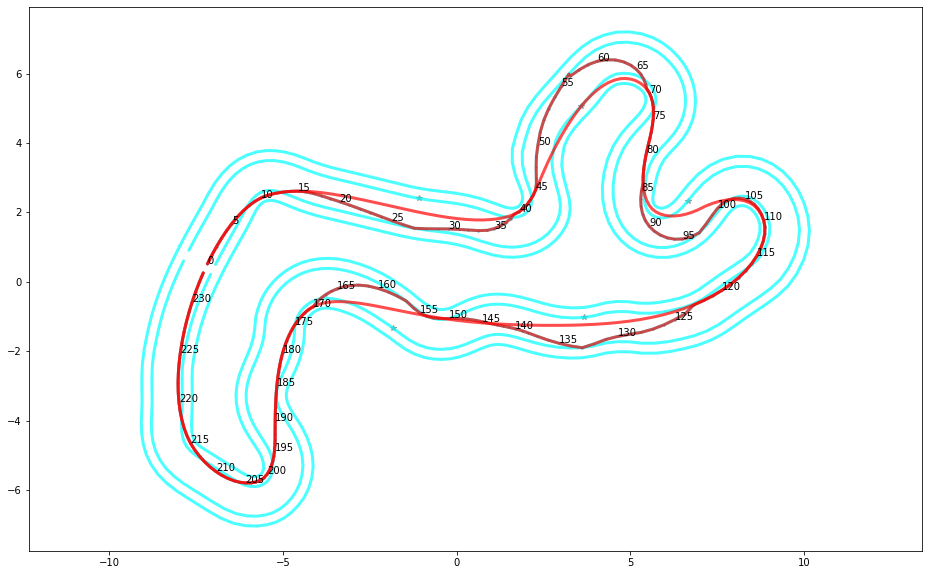

In [15]:
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from matplotlib import pyplot as plt
import numpy as np

def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '*', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def plot_line2(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                     
# Own code: Reduce width of track
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)
    
def print_border(ax, inner_border_waypoints, outer_border_waypoints):
                                                                                
    line = LineString(inner_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    #plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')
print_border(ax, inner_border, outer_border)

# Also print new border
print_border(ax, inner_border_new, outer_border_new)

plot_line(ax, LineString(np.asarray(racing_track_new)[:,0:2]))
plot_line2(ax, LineString(np.asarray(racing_track_new)[:,0:2]))


plot_coords(ax, LineString(objects_location))
#plot_coords(ax, LineString(o2))
#plot_coords(ax, LineString(o3))
plot_points(ax, np.asarray(racing_track_new)[:,0:2])
plot_line2(ax, LineString(np.asarray(racing_track)[:,0:2]))


In [18]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track_new[i][0],
                                    racing_track_new[i][1],
                                    racing_track[i][2],
                                    racing_track[i][3],
                                    center_line[i][0],
                                    center_line[i][0],
                                    inner_border_new[i][0],
                                    inner_border_new[i][1],
                                    outer_border_new[i][0],
                                    outer_border_new[i][1]
                                   ]
                                  )
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()
print(racing_track_everything)

[[-7.17591, 0.52298, 3.49017, 0.0829, -7.3288, -7.3288, -6.94494, 0.50357, -7.71265, 0.90991], [-7.04789, 0.7761, 3.16465, 0.08963, -7.17418, -7.17418, -6.7936, 0.78962, -7.55477, 1.20809], [-6.91386, 1.01896, 2.8488, 0.09737, -7.01496, -7.01496, -6.63701, 1.07452, -7.3929, 1.50244], [-6.77416, 1.25075, 2.50403, 0.10808, -6.85213, -6.85213, -6.47296, 1.36432, -7.2313, 1.78788], [-6.62874, 1.46985, 2.20418, 0.11931, -6.69096, -6.69096, -6.30683, 1.662, -7.0751, 2.06729], [-6.47767, 1.6749, 1.93961, 0.13131, -6.54905, -6.54905, -6.18589, 1.89314, -6.91221, 2.37411], [-6.3209, 1.86422, 1.93961, 0.12673, -6.42023, -6.42023, -6.09133, 2.07174, -6.74913, 2.64979], [-6.15828, 2.036, 1.93961, 0.12195, -6.28247, -6.28247, -5.99585, 2.2319, -6.5691, 2.89526], [-5.98952, 2.18824, 1.93961, 0.11718, -6.13542, -6.13542, -5.89728, 2.36745, -6.37355, 3.10075], [-5.81384, 2.31795, 1.93961, 0.11259, -5.97788, -5.97788, -5.79185, 2.47577, -6.16391, 3.26188], [-5.62991, 2.42181, 1.93961, 0.1089, -5.81035,

In [19]:
from datetime import datetime

now = datetime.now()
prefix = '%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))

# Write to txt file
with open(f'optimals_for_OA_knockouts_{prefix}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")
    print(f)

<_io.TextIOWrapper name='optimals_for_OA_knockouts_Monaco-2020-12-04-054659.txt' mode='w' encoding='UTF-8'>


In [77]:
import math


class Reward:
    def __init__(self, verbose=False):
        self.first_racingpoint_index = 0  # None
        self.verbose = verbose

    def reward_function(self, params):

        # Import package (needed for heading)
        # import math

        ################## HELPER FUNCTIONS From Daniel###################

        def indexes_point_cyclical(point, diff, array_len):
            next_point = point + diff
            if point + diff >= array_len:
                next_point = point + diff - array_len
            elif point + diff < 0:
                next_point = point + diff + array_len
            return next_point

        def indexes_diff_cyclical(point1, point2, array_len):
            diff = point2 - point1
            #print('indexes_diff_cyclical ', point1, point2, array_len)
            #print('diff1 ', diff)
            if diff < 0:
                diff = array_len + diff
                #print('diff2 ', diff)
            if diff > array_len * 0.3:
                diff = array_len - diff
                #print('diff3 ', diff)
            return diff

        ################## HELPER FUNCTIONS ###################

        def dist_2_points(x1, x2, y1, y2):
            return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

        def closest_2_racing_points_index(racing_coords, car_coords):

            # Calculate all distances to racing points
            distances = []
            for i in range(len(racing_coords)):
                distance = dist_2_points(x1=racing_coords[i][0], x2=car_coords[0],
                                         y1=racing_coords[i][1], y2=car_coords[1])
                distances.append(distance)

            # Get index of the closest racing point
            closest_index = distances.index(min(distances))

            # Get index of the second closest racing point
            distances_no_closest = distances.copy()
            distances_no_closest[closest_index] = 999
            second_closest_index = distances_no_closest.index(
                min(distances_no_closest))

            return [closest_index, second_closest_index]

        def dist_to_racing_line(closest_coords, second_closest_coords, car_coords):

            # Calculate the distances between 2 closest racing points
            a = abs(dist_2_points(x1=closest_coords[0],
                                  x2=second_closest_coords[0],
                                  y1=closest_coords[1],
                                  y2=second_closest_coords[1]))

            # Distances between car and closest and second closest racing point
            b = abs(dist_2_points(x1=car_coords[0],
                                  x2=closest_coords[0],
                                  y1=car_coords[1],
                                  y2=closest_coords[1]))
            c = abs(dist_2_points(x1=car_coords[0],
                                  x2=second_closest_coords[0],
                                  y1=car_coords[1],
                                  y2=second_closest_coords[1]))

            # Calculate distance between car and racing line (goes through 2 closest racing points)
            # try-except in case a=0 (rare bug in DeepRacer)
            try:
                distance = abs(-(a**4) + 2*(a**2)*(b**2) + 2*(a**2)*(c**2) -
                               (b**4) + 2*(b**2)*(c**2) - (c**4))**0.5 / (2*a)
            except:
                distance = b

            return distance

        # Calculate which one of the closest racing points is the next one and which one the previous one
        def next_prev_racing_point(closest_coords, second_closest_coords, car_coords, heading):

            # Virtually set the car more into the heading direction
            heading_vector = [math.cos(math.radians(
                heading)), math.sin(math.radians(heading))]
            new_car_coords = [car_coords[0]+heading_vector[0],
                              car_coords[1]+heading_vector[1]]

            # Calculate distance from new car coords to 2 closest racing points
            distance_closest_coords_new = dist_2_points(x1=new_car_coords[0],
                                                        x2=closest_coords[0],
                                                        y1=new_car_coords[1],
                                                        y2=closest_coords[1])
            distance_second_closest_coords_new = dist_2_points(x1=new_car_coords[0],
                                                               x2=second_closest_coords[0],
                                                               y1=new_car_coords[1],
                                                               y2=second_closest_coords[1])

            if distance_closest_coords_new <= distance_second_closest_coords_new:
                next_point_coords = closest_coords
                prev_point_coords = second_closest_coords
            else:
                next_point_coords = second_closest_coords
                prev_point_coords = closest_coords

            return [next_point_coords, prev_point_coords]

        def racing_direction_diff(closest_coords, second_closest_coords, car_coords, heading):

            # Calculate the direction of the center line based on the closest waypoints
            next_point, prev_point = next_prev_racing_point(closest_coords,
                                                            second_closest_coords,
                                                            car_coords,
                                                            heading)

            # Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
            track_direction = math.atan2(
                next_point[1] - prev_point[1], next_point[0] - prev_point[0])

            # Convert to degree
            track_direction = math.degrees(track_direction)

            # Calculate the difference between the track direction and the heading direction of the car
            direction_diff = abs(track_direction - heading)
            if direction_diff > 180:
                direction_diff = 360 - direction_diff

            return direction_diff

        # Gives back indexes that lie between start and end index of a cyclical list
        # (start index is included, end index is not)
        def indexes_cyclical(start, end, array_len):

            if end < start:
                end += array_len

            return [index % array_len for index in range(start, end)]

        # Calculate how long car would take for entire lap, if it continued like it did until now
        def projected_time(first_index, closest_index, step_count, times_list):

            # Calculate how much time has passed since start
            current_actual_time = (step_count-1) / 15

            # Calculate which indexes were already passed
            indexes_traveled = indexes_cyclical(
                first_index, closest_index, len(times_list))

            # Calculate how much time should have passed if car would have followed optimals
            current_expected_time = sum(
                [times_list[i] for i in indexes_traveled])

            # Calculate how long one entire lap takes if car follows optimals
            total_expected_time = sum(times_list)

            # Calculate how long car would take for entire lap, if it continued like it did until now
            try:
                projected_time = (current_actual_time /
                                  current_expected_time) * total_expected_time
            except:
                projected_time = 9999

            return projected_time

        #################### RACING LINE ######################
        # Optimal racing line for the Austin track
        # Each row: [x,y,speed,timeFromPreviousPoint, centerx, centery, innerx, innery, outerx, outery]
        oa_racing_track = [[-7.17591, 0.52298, 3.49017, 0.0829, -7.3288, -7.3288, -6.94494, 0.50357, -7.71265, 0.90991],
                            [-7.04789, 0.7761, 3.16465, 0.08963, -7.17418, -7.17418, -6.7936, 0.78962, -7.55477, 1.20809],
                            [-6.91386, 1.01896, 2.8488, 0.09737, -7.01496, -7.01496, -6.63701, 1.07452, -7.3929, 1.50244],
                            [-6.77416, 1.25075, 2.50403, 0.10808, -6.85213, -6.85213, -6.47296, 1.36432, -7.2313, 1.78788],
                            [-6.62874, 1.46985, 2.20418, 0.11931, -6.69096, -6.69096, -6.30683, 1.662, -7.0751, 2.06729],
                            [-6.47767, 1.6749, 1.93961, 0.13131, -6.54905, -6.54905, -6.18589, 1.89314, -6.91221, 2.37411],
                            [-6.3209, 1.86422, 1.93961, 0.12673, -6.42023, -6.42023, -6.09133, 2.07174, -6.74913, 2.64979],
                            [-6.15828, 2.036, 1.93961, 0.12195, -6.28247, -6.28247, -5.99585, 2.2319, -6.5691, 2.89526],
                            [-5.98952, 2.18824, 1.93961, 0.11718, -6.13542, -6.13542, -5.89728, 2.36745, -6.37355, 3.10075],
                            [-5.81384, 2.31795, 1.93961, 0.11259, -5.97788, -5.97788, -5.79185, 2.47577, -6.16391, 3.26188],
                            [-5.62991, 2.42181, 1.93961, 0.1089, -5.81035, -5.81035, -5.67741, 2.55709, -5.94329, 3.38049],
                            [-5.43479, 2.49528, 2.36482, 0.08817, -5.63307, -5.63307, -5.5523, 2.60992, -5.71384, 3.45675],
                            [-5.23089, 2.54881, 2.60203, 0.08102, -5.44682, -5.44682, -5.41607, 2.63444, -5.47757, 3.49369],
                            [-5.01847, 2.58526, 2.86312, 0.07527, -5.25166, -5.25166, -5.26782, 2.6294, -5.2355, 3.49177],
                            [-4.79764, 2.6066, 3.11086, 0.07132, -5.04577, -5.04577, -5.10478, 2.59572, -4.98676, 3.45374],
                            [-4.56815, 2.61397, 3.40455, 0.06744, -4.8258, -4.8258, -4.92128, 2.53406, -4.73032, 3.38205],
                            [-4.32967, 2.60833, 3.6, 0.06626, -4.58896, -4.58896, -4.7087, 2.44791, -4.46921, 3.28482],
                            [-4.08205, 2.59085, 3.6, 0.06895, -4.31685, -4.31685, -4.43312, 2.33917, -4.20059, 3.17877],
                            [-3.82492, 2.56241, 3.6, 0.07186, -4.02172, -4.02172, -4.12962, 2.23903, -3.91382, 3.08201],
                            [-3.55823, 2.52423, 3.6, 0.07484, -3.72187, -3.72187, -3.82129, 2.15435, -3.62246, 2.9999],
                            [-3.28202, 2.47752, 3.6, 0.07781, -3.40015, -3.40015, -3.50054, 2.07893, -3.29976, 2.92402],
                            [-2.99642, 2.4234, 3.6, 0.08075, -3.07858, -3.07858, -3.18118, 2.00305, -2.97598, 2.84708],
                            [-2.70174, 2.36304, 3.6, 0.08355, -2.75743, -2.75743, -2.86085, 1.92518, -2.65401, 2.76881],
                            [-2.39866, 2.29765, 3.6, 0.08613, -2.43642, -2.43642, -2.54095, 1.84675, -2.33189, 2.68983],
                            [-2.08831, 2.22855, 3.6, 0.08832, -2.11562, -2.11562, -2.21915, 1.76696, -2.0121, 2.61053],
                            [-1.77317, 2.15733, 3.6, 0.08975, -1.79464, -1.79464, -1.89126, 1.68654, -1.69801, 2.53338],
                            [-1.4557, 2.08647, 3.6, 0.09036, -1.47242, -1.47242, -1.55595, 1.61023, -1.38888, 2.46262],
                            [-1.14182, 2.01897, 3.6, 0.08918, -1.1481, -1.1481, -1.21488, 1.54372, -1.08132, 2.402],
                            [-0.83483, 1.95714, 3.6, 0.08699, -0.82153, -0.82153, -0.8741, 1.49093, -0.76895, 2.35315],
                            [-0.53778, 1.9029, 3.43633, 0.08787, -0.49347, -0.49347, -0.54459, 1.45074, -0.44236, 2.31332],
                            [-0.25308, 1.85778, 3.05477, 0.09436, -0.16524, -0.16524, -0.23739, 1.41486, -0.09308, 2.2714],
                            [0.01774, 1.82281, 2.73865, 0.09971, 0.15957, 0.15957, 0.07161, 1.35847, 0.24754, 2.21076],
                            [0.2739, 1.79859, 2.41331, 0.10662, 0.47961, 0.47961, 0.37605, 1.28115, 0.58317, 2.1274],
                            [0.51516, 1.78546, 2.14151, 0.11283, 0.79352, 0.79352, 0.72432, 1.16892, 0.86272, 2.03652],
                            [0.74168, 1.78358, 1.90867, 0.11868, 1.10756, 1.10756, 1.07427, 1.06569, 1.14085, 1.94172],
                            [0.95413, 1.79271, 1.69546, 0.12543, 1.30769, 1.30769, 1.33297, 1.01629, 1.2824, 1.90051],
                            [1.15237, 1.81335, 1.48929, 0.13383, 1.50557, 1.50557, 1.58929, 0.999, 1.42184, 1.87061],
                            [1.3365, 1.84587, 1.48929, 0.12555, 1.69237, 1.69237, 1.83142, 1.01584, 1.55332, 1.85626],
                            [1.50616, 1.89112, 1.48929, 0.11791, 1.86645, 1.86645, 2.05693, 1.06434, 1.67596, 1.85842],
                            [1.6611, 1.95001, 1.48929, 0.11129, 2.02777, 2.02777, 2.2648, 1.1417, 1.79075, 1.87787],
                            [1.80084, 2.0238, 1.48929, 0.10611, 2.17854, 2.17854, 2.45758, 1.25136, 1.89949, 1.91877],
                            [1.92424, 2.11477, 1.48929, 0.10294, 2.31339, 2.31339, 2.62942, 1.38948, 1.99736, 1.98231],
                            [2.02878, 2.22832, 1.91298, 0.08068, 2.42787, 2.42787, 2.77623, 1.55569, 2.07952, 2.07074],
                            [2.12242, 2.35792, 2.20883, 0.07238, 2.51518, 2.51518, 2.89159, 1.74696, 2.13877, 2.18516],
                            [2.20774, 2.50253, 2.59829, 0.06462, 2.56694, 2.56694, 2.96716, 1.96545, 2.16672, 2.33168],
                            [2.2868, 2.66107, 3.207, 0.05524, 2.56894, 2.56894, 2.98869, 2.20813, 2.14918, 2.50853],
                            [2.36154, 2.8312, 3.6, 0.05162, 2.51447, 2.51447, 2.9503, 2.47877, 2.07864, 2.73447],
                            [2.43403, 3.00817, 3.6, 0.05312, 2.4257, 2.4257, 2.86992, 2.76626, 1.98148, 3.00292],
                            [2.53618, 3.2458, 3.6, 0.07185, 2.33593, 2.33593, 2.7775, 3.13445, 1.89436, 3.37601],
                            [2.64502, 3.48503, 3.6, 0.07301, 2.31597, 2.31597, 2.74195, 3.45427, 1.89, 3.74433],
                            [2.75998, 3.72341, 3.6, 0.07351, 2.37875, 2.37875, 2.78051, 3.73624, 1.977, 4.10633],
                            [2.88068, 3.95899, 3.48139, 0.07603, 2.47881, 2.47881, 2.84984, 4.06093, 2.10778, 4.52027],
                            [3.0069, 4.19, 3.15132, 0.08353, 2.63647, 2.63647, 2.98535, 4.34568, 2.28759, 4.86208],
                            [3.13848, 4.41461, 2.83413, 0.09185, 2.83445, 2.83445, 3.16455, 4.60124, 2.50434, 5.16218],
                            [3.27526, 4.63107, 2.53072, 0.10118, 3.05654, 3.05654, 3.37, 4.83801, 2.74308, 5.43867],
                            [3.41721, 4.83734, 2.24385, 0.11159, 3.28761, 3.28761, 3.58565, 5.06562, 2.98957, 5.70879],
                            [3.56425, 5.03148, 2.01288, 0.12099, 3.51403, 3.51403, 3.79229, 5.29453, 3.23578, 5.98618],
                            [3.71646, 5.21119, 1.75692, 0.13405, 3.51403, 3.51403, 3.79229, 5.29453, 3.23578, 5.98618],
                            [3.87372, 5.37439, 1.53013, 0.14812, 3.71557, 3.71557, 3.95715, 5.48857, 3.47399, 6.24701],
                            [4.03579, 5.51877, 1.53013, 0.14185, 3.91505, 3.91505, 4.1068, 5.65928, 3.72331, 6.48211],
                            [4.20206, 5.64167, 1.48211, 0.1395, 4.12356, 4.12356, 4.25531, 5.80191, 3.9918, 6.67376],
                            [4.37133, 5.74002, 1.48211, 0.13209, 4.35028, 4.35028, 4.4162, 5.90839, 4.28436, 6.80745],
                            [4.54149, 5.81132, 1.48211, 0.12448, 4.59738, 4.59738, 4.59535, 5.98519, 4.59941, 6.89101],
                            [4.70906, 5.85186, 1.47072, 0.11723, 4.85386, 4.85386, 4.78512, 6.00889, 4.92259, 6.90205],
                            [4.86822, 5.8585, 1.40511, 0.11337, 5.1027, 5.1027, 4.96983, 6.00022, 5.23557, 6.85948],
                            [5.01683, 5.84004, 1.40511, 0.10658, 5.32325, 5.32325, 5.12988, 5.96442, 5.51661, 6.76983],
                            [5.15165, 5.79737, 1.40511, 0.10064, 5.52923, 5.52923, 5.28098, 5.90067, 5.77748, 6.63172],
                            [5.27312, 5.73579, 1.40511, 0.09692, 5.68663, 5.68663, 5.38968, 5.82966, 5.98358, 6.47346],
                            [5.38056, 5.65709, 1.40511, 0.09478, 5.82282, 5.82282, 5.48436, 5.75255, 6.16129, 6.29681],
                            [5.47266, 5.56196, 1.40511, 0.09424, 5.9386, 5.9386, 5.56684, 5.67037, 6.31037, 6.10846],
                            [5.5466, 5.44974, 1.49016, 0.09018, 6.03395, 6.03395, 5.63656, 5.57779, 6.43134, 5.90145],
                            [5.60237, 5.32241, 1.6588, 0.0838, 6.10464, 6.10464, 5.68941, 5.47598, 6.51986, 5.68186],
                            [5.64118, 5.18225, 1.82616, 0.07964, 6.15078, 6.15078, 5.72612, 5.35453, 6.57545, 5.45289],
                            [5.66358, 5.03056, 2.01705, 0.07602, 6.16492, 6.16492, 5.73642, 5.22799, 6.59342, 5.21794],
                            [5.67001, 4.8683, 2.28004, 0.07122, 6.14683, 6.14683, 5.71926, 5.09513, 6.57441, 4.98122],
                            [5.66159, 4.69663, 2.64575, 0.06496, 6.07997, 6.07997, 5.65035, 4.91585, 6.50959, 4.72578],
                            [5.6402, 4.517, 3.03562, 0.05959, 5.97438, 5.97438, 5.54728, 4.75162, 6.40147, 4.48539],
                            [5.60743, 4.33049, 3.11056, 0.06088, 5.82337, 5.82337, 5.39959, 4.57567, 6.24715, 4.25389],
                            [5.56559, 4.13852, 2.69764, 0.07283, 5.63458, 5.63458, 5.2128, 4.3769, 6.05636, 4.03408],
                            [5.51715, 3.94258, 2.37879, 0.08485, 5.42804, 5.42804, 5.00117, 4.13131, 5.85491, 3.81986],
                            [5.46384, 3.70634, 2.10831, 0.11487, 5.24187, 5.24187, 4.8044, 3.83628, 5.67935, 3.59469],
                            [5.4197, 3.47608, 1.86234, 0.12589, 5.10258, 5.10258, 4.64759, 3.48552, 5.55756, 3.35443],
                            [5.38802, 3.25428, 1.66132, 0.13486, 5.01512, 5.01512, 4.55111, 3.12611, 5.47913, 3.11318],
                            [5.37113, 3.04311, 1.45706, 0.14539, 4.97181, 4.97181, 4.50726, 2.79123, 5.43636, 2.90649],
                            [5.37072, 2.84455, 1.28996, 0.15392, 4.96022, 4.96022, 4.50839, 2.46323, 5.41204, 2.70829],
                            [5.38761, 2.66027, 1.28996, 0.14346, 4.97745, 4.97745, 4.55297, 2.15277, 5.40194, 2.52579],
                            [5.42214, 2.49182, 1.28996, 0.13331, 5.02316, 5.02316, 4.64021, 1.86785, 5.40611, 2.36135],
                            [5.4745, 2.34094, 1.28996, 0.12381, 5.09691, 5.09691, 4.76564, 1.62158, 5.42818, 2.22215],
                            [5.54445, 2.2093, 1.28996, 0.11556, 5.19666, 5.19666, 4.92329, 1.41436, 5.47003, 2.10499],
                            [5.63234, 2.09985, 1.28996, 0.10882, 5.32215, 5.32215, 5.11125, 1.24577, 5.53305, 2.00658],
                            [5.73847, 2.01652, 1.3402, 0.10069, 5.46986, 5.46986, 5.32409, 1.11876, 5.61562, 1.92922],
                            [5.85902, 1.957, 1.4714, 0.09137, 5.63068, 5.63068, 5.54891, 1.0362, 5.71246, 1.87611],
                            [5.99085, 1.91832, 1.61931, 0.08485, 5.80767, 5.80767, 5.78733, 0.99262, 5.828, 1.84532],
                            [6.1321, 1.8987, 1.74845, 0.08156, 5.99165, 5.99165, 6.03085, 0.99005, 5.95246, 1.84154],
                            [6.28182, 1.89778, 1.91119, 0.07834, 6.17338, 6.17338, 6.27135, 1.02997, 6.0754, 1.86511],
                            [6.43919, 1.91519, 2.10787, 0.07511, 6.36125, 6.36125, 6.51348, 1.11215, 6.20902, 1.91933],
                            [6.60358, 1.95048, 2.298, 0.07317, 6.55223, 6.55223, 6.75498, 1.23908, 6.34949, 2.00865],
                            [6.77507, 2.00395, 2.25292, 0.07973, 6.74296, 6.74296, 6.98904, 1.41667, 6.49688, 2.14292],
                            [6.95492, 2.0771, 2.03202, 0.09555, 6.92857, 6.92857, 7.20251, 1.63319, 6.65463, 2.32573],
                            [7.14736, 2.17367, 1.83139, 0.11757, 7.13276, 7.13276, 7.4077, 1.88219, 6.85782, 2.5762],
                            [7.34749, 2.25428, 1.64136, 0.13145, 7.3353, 7.3353, 7.56574, 2.07968, 7.10486, 2.84318],
                            [7.54488, 2.31427, 1.47173, 0.14018, 7.55274, 7.55274, 7.71504, 2.23809, 7.39044, 3.0707],
                            [7.73813, 2.35398, 1.32694, 0.14868, 7.78862, 7.78862, 7.86725, 2.35778, 7.70998, 3.2351],
                            [7.9258, 2.3724, 1.32694, 0.14211, 8.03316, 8.03316, 8.02102, 2.43392, 8.04531, 3.32058],
                            [8.10596, 2.36784, 1.32694, 0.13582, 8.27454, 8.27454, 8.17328, 2.46738, 8.3758, 3.32566],
                            [8.27617, 2.33854, 1.32694, 0.13016, 8.49121, 8.49121, 8.31336, 2.46477, 8.66905, 3.26683],
                            [8.43304, 2.28228, 1.32694, 0.12559, 8.69688, 8.69688, 8.44976, 2.43003, 8.944, 3.14745],
                            [8.57166, 2.19643, 1.32694, 0.12288, 8.8834, 8.8834, 8.57795, 2.36568, 9.18885, 2.97801],
                            [8.68431, 2.0779, 1.56327, 0.1046, 9.05003, 9.05003, 8.69734, 2.2717, 9.40272, 2.76268],
                            [8.77518, 1.93743, 1.56327, 0.10702, 9.19513, 9.19513, 8.80647, 2.14776, 9.58379, 2.50428],
                            [8.84207, 1.77658, 1.56327, 0.11143, 9.31545, 9.31545, 8.90224, 1.99436, 9.72866, 2.20647],
                            [8.8773, 1.59414, 1.59525, 0.11648, 9.40401, 9.40401, 8.97775, 1.81251, 9.83027, 1.87464],
                            [8.87339, 1.39265, 1.84129, 0.10945, 9.44703, 9.44703, 9.0196, 1.60279, 9.87445, 1.51493],
                            [8.83254, 1.17983, 2.01489, 0.10755, 9.42655, 9.42655, 9.01018, 1.36777, 9.84293, 1.13673],
                            [8.75471, 0.96127, 2.23356, 0.10387, 9.33758, 9.33758, 8.94334, 1.11558, 9.73182, 0.75519],
                            [8.6422, 0.74215, 2.425, 0.10157, 9.19283, 9.19283, 8.82906, 0.86869, 9.55659, 0.39528],
                            [8.49708, 0.52682, 2.62189, 0.09904, 8.9962, 8.9962, 8.66666, 0.63798, 9.32574, 0.07301],
                            [8.32213, 0.31895, 2.8251, 0.09617, 8.74072, 8.74072, 8.44197, 0.44062, 9.03946, -0.19038],
                            [8.12063, 0.12139, 3.03366, 0.09302, 8.46093, 8.46093, 8.18539, 0.26115, 8.73647, -0.41234],
                            [7.89604, -0.06383, 3.24563, 0.0897, 8.17584, 8.17584, 7.91711, 0.08414, 8.43457, -0.61586],
                            [7.65175, -0.23546, 3.4309, 0.08702, 7.89297, 7.89297, 7.64764, -0.0995, 8.13829, -0.81822],
                            [7.39064, -0.39262, 3.6, 0.08466, 7.61171, 7.61171, 7.37961, -0.29089, 7.8438, -1.02661],
                            [7.11526, -0.53481, 3.6, 0.08609, 7.32414, 7.32414, 7.10802, -0.48018, 7.54026, -1.23475],
                            [6.82795, -0.66189, 3.6, 0.08727, 7.01304, 7.01304, 6.8265, -0.63115, 7.19958, -1.41675],
                            [6.53081, -0.77404, 3.6, 0.08822, 6.68129, 6.68129, 6.52555, -0.74054, 6.83702, -1.55213],
                            [6.22574, -0.87171, 3.6, 0.08898, 6.33574, 6.33574, 6.21352, -0.81372, 6.45796, -1.64778],
                            [5.91436, -0.95555, 3.6, 0.08957, 5.99051, 5.99051, 5.90154, -0.87342, 6.07947, -1.72422],
                            [5.59812, -1.02639, 3.6, 0.09002, 5.6433, 5.6433, 5.58618, -0.90378, 5.70042, -1.76506],
                            [5.27826, -1.08518, 3.6, 0.09034, 5.2972, 5.2972, 5.26829, -0.89976, 5.32612, -1.76516],
                            [4.95592, -1.13296, 3.6, 0.09052, 4.96102, 4.96102, 4.94327, -0.85955, 4.97877, -1.72652],
                            [4.63224, -1.17083, 3.6, 0.09052, 4.62795, 4.62795, 4.62036, -0.85394, 4.63553, -1.72244],
                            [4.30846, -1.1999, 3.6, 0.0903, 4.29749, 4.29749, 4.30003, -0.88981, 4.29495, -1.75989],
                            [3.986, -1.22131, 3.6, 0.08977, 3.97116, 3.97116, 3.98296, -0.97004, 3.95936, -1.84143],
                            [3.66655, -1.2362, 3.6, 0.08883, 3.63923, 3.63923, 3.6605, -1.02538, 3.61795, -1.89586],
                            [3.35186, -1.24571, 3.6, 0.08745, 3.30748, 3.30748, 3.34581, -1.0375, 3.26915, -1.9051],
                            [3.04377, -1.25096, 3.6, 0.08559, 2.97614, 2.97614, 3.0314, -1.0187, 2.92088, -1.88127],
                            [2.74802, -1.25268, 3.6, 0.08216, 2.64932, 2.64932, 2.72787, -0.97281, 2.57078, -1.82762],
                            [2.48052, -1.25163, 3.6, 0.07431, 2.32737, 2.32737, 2.42683, -0.90069, 2.22791, -1.74617],
                            [2.23813, -1.24859, 3.6, 0.06734, 2.00964, 2.00964, 2.10551, -0.80681, 1.91377, -1.65405],
                            [2.00959, -1.24395, 3.6, 0.0635, 1.76774, 1.76774, 1.83768, -0.73358, 1.69781, -1.59191],
                            [1.78954, -1.2378, 3.6, 0.06115, 1.5231, 1.5231, 1.56671, -0.67556, 1.47949, -1.54063],
                            [1.57532, -1.23007, 3.6, 0.05954, 1.35324, 1.35324, 1.37098, -0.65125, 1.3355, -1.51998],
                            [1.36497, -1.22073, 3.6, 0.05849, 1.19586, 1.19586, 1.19025, -0.64101, 1.20147, -1.51107],
                            [1.15735, -1.20966, 3.6, 0.05775, 1.03452, 1.03452, 1.00593, -0.64891, 1.06311, -1.51843],
                            [0.95165, -1.19671, 3.6, 0.05725, 0.87245, 0.87245, 0.82348, -0.67401, 0.92142, -1.54272],
                            [0.74727, -1.18172, 3.6, 0.05693, 0.71128, 0.71128, 0.64638, -0.71864, 0.77618, -1.58685],
                            [0.54371, -1.16457, 3.6, 0.05674, 0.5508, 0.5508, 0.47533, -0.77498, 0.62626, -1.64385],
                            [0.34063, -1.14504, 3.6, 0.05667, 0.39081, 0.39081, 0.30929, -0.8413, 0.47234, -1.70891],
                            [0.13772, -1.12298, 3.6, 0.0567, 0.20989, 0.20989, 0.15333, -0.91167, 0.26644, -1.79384],
                            [-0.06528, -1.09832, 3.6, 0.0568, 0.02712, 0.02712, 0.003, -0.9779, 0.05124, -1.86757],
                            [-0.26855, -1.07101, 3.6, 0.05697, -0.15986, -0.15986, -0.15046, -1.0341, -0.16927, -1.91947],
                            [-0.47224, -1.04109, 3.6, 0.05719, -0.35081, -0.35081, -0.3022, -1.07013, -0.39943, -1.94342],
                            [-0.67644, -1.00867, 3.6, 0.05743, -0.53787, -0.53787, -0.45111, -1.08149, -0.62462, -1.93513],
                            [-0.88118, -0.97393, 3.6, 0.05769, -0.72639, -0.72639, -0.6034, -1.06793, -0.84938, -1.89777],
                            [-1.08646, -0.93709, 3.6, 0.05793, -0.9641, -0.9641, -0.82005, -0.99989, -1.10816, -1.81103],
                            [-1.29226, -0.89846, 3.6, 0.05816, -1.18586, -1.18586, -1.0211, -0.89031, -1.35062, -1.68413],
                            [-1.49848, -0.85839, 3.6, 0.05836, -1.41055, -1.41055, -1.22984, -0.73297, -1.59126, -1.51289],
                            [-1.70505, -0.81724, 3.6, 0.05851, -1.64484, -1.64484, -1.45433, -0.54882, -1.83536, -1.32714],
                            [-1.91184, -0.7754, 3.6, 0.05861, -1.89475, -1.89475, -1.7015, -0.37416, -2.088, -1.15354],
                            [-2.11836, -0.73396, 3.46622, 0.06077, -2.1555, -2.1555, -1.966, -0.19954, -2.34499, -0.98266],
                            [-2.32397, -0.69418, 3.01372, 0.06949, -2.42736, -2.42736, -2.24605, -0.03493, -2.60866, -0.8234],
                            [-2.5279, -0.65741, 2.65043, 0.07818, -2.7255, -2.7255, -2.57607, 0.12405, -2.87493, -0.69154],
                            [-2.7294, -0.62488, 2.32453, 0.08781, -2.99623, -2.99623, -2.88922, 0.24063, -3.10323, -0.60345],
                            [-2.92751, -0.59819, 2.03364, 0.0983, -3.2191, -3.2191, -3.15846, 0.31779, -3.27974, -0.54698],
                            [-3.12121, -0.57886, 1.78014, 0.10935, -3.4286, -3.4286, -3.41617, 0.36607, -3.44103, -0.50725],
                            [-3.30948, -0.5684, 1.64316, 0.11475, -3.62588, -3.62588, -3.66307, 0.38815, -3.58868, -0.48187],
                            [-3.49116, -0.56853, 1.64316, 0.11057, -3.81219, -3.81219, -3.89901, 0.3817, -3.72536, -0.47236],
                            [-3.66515, -0.58083, 1.64316, 0.10616, -3.98976, -3.98976, -4.12545, 0.34941, -3.85407, -0.47758],
                            [-3.83023, -0.60709, 1.64316, 0.10173, -4.15793, -4.15793, -4.34045, 0.2903, -3.97541, -0.49857],
                            [-3.98492, -0.64939, 1.64316, 0.09759, -4.31684, -4.31684, -4.54351, 0.20615, -4.09016, -0.5345],
                            [-4.12732, -0.7103, 1.64316, 0.09426, -4.46639, -4.46639, -4.73393, 0.09616, -4.19884, -0.58612],
                            [-4.25618, -0.79128, 1.81361, 0.08391, -4.6019, -4.6019, -4.90663, -0.03395, -4.29716, -0.64998],
                            [-4.37392, -0.88823, 1.98955, 0.07666, -4.72392, -4.72392, -5.05885, -0.1796, -4.389, -0.72749],
                            [-4.482, -0.99858, 2.15293, 0.07175, -4.83219, -4.83219, -5.19306, -0.34066, -4.47131, -0.81703],
                            [-4.58124, -1.12073, 2.31599, 0.06795, -4.92321, -4.92321, -5.30497, -0.51503, -4.54145, -0.9197],
                            [-4.67215, -1.25348, 2.47519, 0.065, -4.99499, -4.99499, -5.39219, -0.69825, -4.5978, -1.03713],
                            [-4.75505, -1.3959, 2.65954, 0.06196, -5.0464, -5.0464, -5.45558, -0.88252, -4.63722, -1.16184],
                            [-4.83033, -1.54702, 2.80586, 0.06017, -5.07961, -5.07961, -5.49835, -1.05577, -4.66087, -1.2854],
                            [-4.89806, -1.70622, 2.96357, 0.05838, -5.09303, -5.09303, -5.5176, -1.22468, -4.66845, -1.41717],
                            [-4.95839, -1.87285, 3.13487, 0.05653, -5.11031, -5.11031, -5.53513, -1.44527, -4.6855, -1.6456],
                            [-5.01146, -2.04625, 3.32059, 0.05461, -5.15661, -5.15661, -5.57783, -1.69738, -4.73539, -1.92643],
                            [-5.05751, -2.22569, 3.52189, 0.0526, -5.23431, -5.23431, -5.65487, -1.95628, -4.81376, -2.19334],
                            [-5.09682, -2.41046, 3.6, 0.05247, -5.33733, -5.33733, -5.75891, -2.21476, -4.91575, -2.44909],
                            [-5.12974, -2.59984, 3.6, 0.05339, -5.44067, -5.44067, -5.86805, -2.46466, -5.0133, -2.65852],
                            [-5.15671, -2.79312, 3.6, 0.05421, -5.53707, -5.53707, -5.96678, -2.718, -5.10735, -2.86915],
                            [-5.17823, -2.98964, 3.6, 0.05492, -5.60104, -5.60104, -6.03553, -2.97303, -5.16655, -3.04392],
                            [-5.19493, -3.18876, 3.6, 0.05551, -5.62954, -5.62954, -6.06438, -3.22172, -5.1947, -3.2107],
                            [-5.20754, -3.38989, 3.6, 0.05598, -5.62338, -5.62338, -6.05571, -3.46351, -5.19104, -3.3746],
                            [-5.21681, -3.59254, 3.6, 0.05635, -5.58355, -5.58355, -6.01216, -3.69695, -5.15495, -3.53805],
                            [-5.22314, -3.79641, 3.36703, 0.06058, -5.51137, -5.51137, -5.93641, -3.92185, -5.08634, -3.70474],
                            [-5.22685, -4.00128, 2.80195, 0.07313, -5.40969, -5.40969, -5.83252, -4.13817, -4.98686, -3.88087],
                            [-5.22814, -4.20699, 2.40416, 0.08556, -5.28576, -5.28576, -5.70913, -4.34605, -4.86239, -4.0758],
                            [-5.2274, -4.37682, 2.10874, 0.08054, -5.15319, -5.15319, -5.58094, -4.54386, -4.72543, -4.29772],
                            [-5.22892, -4.54471, 1.84661, 0.09092, -5.03264, -5.03264, -5.46831, -4.72499, -4.59697, -4.54465],
                            [-5.23476, -4.70899, 1.61153, 0.10201, -4.95249, -4.95249, -5.39506, -4.86783, -4.50992, -4.77673],
                            [-5.24673, -4.86836, 1.42417, 0.11222, -4.89642, -4.89642, -5.34231, -4.99903, -4.45053, -5.01187],
                            [-5.26677, -5.02152, 1.24246, 0.12432, -4.86708, -4.86708, -5.3065, -5.14229, -4.42765, -5.28411],
                            [-5.29668, -5.16722, 1.2, 0.12395, -4.8723, -4.8723, -5.29295, -5.27928, -4.45164, -5.55304],
                            [-5.33799, -5.3042, 1.2, 0.11923, -4.91017, -4.91017, -5.29989, -5.4106, -4.52045, -5.80992],
                            [-5.39244, -5.4307, 1.2, 0.11477, -4.97355, -4.97355, -5.32465, -5.52013, -4.62246, -6.03233],
                            [-5.46213, -5.54426, 1.2, 0.11103, -5.06051, -5.06051, -5.3659, -5.61677, -4.75512, -6.22465],
                            [-5.54926, -5.64164, 1.2, 0.10889, -5.16501, -5.16501, -5.4207, -5.70335, -4.90932, -6.39316],
                            [-5.6575, -5.71665, 1.2, 0.10975, -5.2891, -5.2891, -5.49128, -5.77868, -5.08692, -6.53562],
                            [-5.78742, -5.76364, 1.48513, 0.09302, -5.43447, -5.43447, -5.57967, -5.83895, -5.28927, -6.64612],
                            [-5.93125, -5.78823, 1.62931, 0.08956, -5.60414, -5.60414, -5.68892, -5.87859, -5.51936, -6.71624],
                            [-6.08651, -5.79021, 1.77517, 0.08747, -5.79408, -5.79408, -5.81591, -5.89654, -5.77224, -6.74893],
                            [-6.25071, -5.76913, 1.93106, 0.08572, -6.00899, -6.00899, -5.96424, -5.88542, -6.05373, -6.73766],
                            [-6.42095, -5.72495, 2.08121, 0.08451, -6.24488, -6.24488, -6.13095, -5.84136, -6.35882, -6.67194],
                            [-6.59409, -5.65799, 2.21302, 0.08389, -6.49496, -6.49496, -6.31284, -5.75574, -6.67707, -6.53959],
                            [-6.76689, -5.56889, 2.35902, 0.08241, -6.78104, -6.78104, -6.55083, -5.60903, -7.01125, -6.34558],
                            [-6.93636, -5.45926, 2.34732, 0.08599, -7.06133, -7.06133, -6.82946, -5.43486, -7.29321, -6.16932],
                            [-7.10009, -5.33067, 2.34732, 0.08869, -7.34077, -7.34077, -7.1069, -5.25969, -7.57464, -5.99161],
                            [-7.2562, -5.18468, 2.34732, 0.09106, -7.6193, -7.6193, -7.36509, -5.09551, -7.8735, -5.79979],
                            [-7.40306, -5.02242, 2.34732, 0.09323, -7.82818, -7.82818, -7.51922, -4.99227, -8.13714, -5.60128],
                            [-7.53934, -4.845, 2.34732, 0.09531, -8.016, -8.016, -7.66108, -4.87519, -8.37093, -5.37157],
                            [-7.66207, -4.65143, 2.34732, 0.09764, -8.15832, -8.15832, -7.7697, -4.74983, -8.54693, -5.12552],
                            [-7.76462, -4.43833, 2.63065, 0.0899, -8.25799, -8.25799, -7.8468, -4.61315, -8.66918, -4.87333],
                            [-7.84869, -4.21013, 2.85448, 0.0852, -8.31873, -8.31873, -7.89391, -4.4622, -8.74356, -4.61617],
                            [-7.91526, -3.9691, 3.07747, 0.08125, -8.34984, -8.34984, -7.91765, -4.3007, -8.78203, -4.35409],
                            [-7.96524, -3.71701, 3.30398, 0.07779, -8.35869, -8.35869, -7.9246, -4.08765, -8.79278, -4.0601],
                            [-7.99943, -3.45528, 3.55091, 0.07433, -8.34821, -8.34821, -7.91421, -3.75974, -8.78222, -3.72732],
                            [-8.01875, -3.18528, 3.6, 0.07519, -8.33588, -8.33588, -7.90163, -3.40612, -8.77013, -3.42044],
                            [-8.02378, -2.90811, 3.6, 0.077, -8.34133, -8.34133, -7.90703, -3.07968, -8.77562, -3.0859],
                            [-8.01506, -2.62485, 3.6, 0.07872, -8.34369, -8.34369, -7.90973, -2.76973, -8.77765, -2.73503],
                            [-7.99314, -2.33663, 3.6, 0.08029, -8.33049, -8.33049, -7.89937, -2.47468, -8.7616, -2.36957],
                            [-7.9586, -2.04463, 3.6, 0.08168, -8.29051, -8.29051, -7.86392, -2.17571, -8.7171, -2.01267],
                            [-7.912, -1.7501, 3.6, 0.08283, -8.22847, -8.22847, -7.80406, -1.86176, -8.65287, -1.67733],
                            [-7.85391, -1.45438, 3.6, 0.08371, -8.1583, -8.1583, -7.73761, -1.55452, -8.57898, -1.33869],
                            [-7.78492, -1.15893, 3.6, 0.08428, -8.07618, -8.07618, -7.66085, -1.25347, -8.4915, -0.99946],
                            [-7.70559, -0.8653, 3.6, 0.08449, -7.97953, -7.97953, -7.56969, -0.95414, -8.38937, -0.66673],
                            [-7.61652, -0.57508, 3.6, 0.08433, -7.87017, -7.87017, -7.4661, -0.65777, -8.27425, -0.33935],
                            [-7.51834, -0.28982, 3.6, 0.0838, -7.74902, -7.74902, -7.35091, -0.36467, -8.14713, -0.01748],
                            [-7.41177, -0.0109, 3.6, 0.08294, -7.61692, -7.61692, -7.22398, -0.07311, -8.00986, 0.29686],
                            [-7.29742, 0.26039, 3.6, 0.08178, -7.47615, -7.47615, -7.08739, 0.21727, -7.8649, 0.60453]]

        #oa_racing_track = np.asarray(oa_racing_track)

        center_line = []
        inner_border_new = []
        outer_border_new = []
        racing_track = []

        for i in range(len(oa_racing_track)):
            racing_track.append([oa_racing_track[i][0], oa_racing_track[i][1], oa_racing_track[i][2], oa_racing_track[i][3]])
            center_line.append([oa_racing_track[i][4], oa_racing_track[i][5]])
            inner_border_new.append([oa_racing_track[i][6], oa_racing_track[i][7]])
            outer_border_new.append([oa_racing_track[i][8], oa_racing_track[i][9]])

        ################## INPUT PARAMETERS ###################

        # Read all input parameters
        all_wheels_on_track = params['all_wheels_on_track']
        x = params['x']
        y = params['y']
        distance_from_center = params['distance_from_center']
        is_left_of_center = params['is_left_of_center']
        heading = params['heading']
        progress = params['progress']
        steps = params['steps']
        speed = params['speed']
        steering_angle = params['steering_angle']
        track_width = params['track_width']
        waypoints = params['waypoints']
        closest_waypoints = params['closest_waypoints']
        is_offtrack = params['is_offtrack']

        objects_location = params['objects_location']
        track_length = params['track_length']

        max_step = len(racing_track)
        step_length = track_length / max_step

        track_width_half = track_width / 2
        object_lookahead = 5
        object_threshold = object_lookahead * track_width_half
        object_threshold_step_number = int(object_threshold / step_length)

        print('max_step', max_step)
        print('step_length', step_length)

        print('track_width_half', track_width_half)
        print('object_threshold', object_threshold)
        print('object_threshold_step_number', object_threshold_step_number)

        objects_waypoint_index = []
        objects_lookahead_waypoint_index1 = []
        objects_lookahead_waypoint_index2 = []


        for i in range(len(objects_location)):
            distances = []
            for j in range(len(racing_track)):
                distance = dist_2_points(x1=racing_track[j][0], x2=objects_location[i][0],
                                    y1=racing_track[j][1], y2=objects_location[i][1])
                distances.append(distance)
            obstacle_index = distances.index(min(distances))
            objects_waypoint_index.append(obstacle_index)
            objects_lookahead_waypoint_index1.append(indexes_point_cyclical(obstacle_index, -1 * object_threshold_step_number, len(racing_track)))
            objects_lookahead_waypoint_index2.append(-1)
        print('objects_waypoint_index',objects_waypoint_index)
        print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
        print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)
        for i in range(len(objects_location)):
            idx = i+1
            if idx >= len(objects_location):
                idx = 0
            if objects_waypoint_index[i] > objects_lookahead_waypoint_index1[idx] and objects_waypoint_index[i] - objects_lookahead_waypoint_index1[idx] < max_step * 0.3:
                objects_lookahead_waypoint_index1[idx] = objects_waypoint_index[i]

        print('objects_waypoint_index',objects_waypoint_index)
        print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
        print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)


        racing_track_new = []


        for idx in range(objects_waypoint_index[0], len(racing_track) + objects_waypoint_index[0]):
            i = idx
            if idx >= len(racing_track):
                i = idx - len(racing_track)
            
            object_waypoint_index = -1
            for j in range(len(objects_waypoint_index)):
                if i < objects_waypoint_index[j]:
                    object_waypoint_index = objects_waypoint_index[j]
                    object_location = objects_location[j]
                    object_index = j
                    break
            if object_waypoint_index == -1:
                object_waypoint_index = objects_waypoint_index[0]
                object_location = objects_location[0]
                object_index = 0
                
            distance = dist_2_points(x1=racing_track[i][0], x2=object_location[0],
                            y1=racing_track[i][1], y2=object_location[1])

            if distance <= object_threshold:
                waypont_len_to_object = indexes_diff_cyclical(i, object_waypoint_index, len(racing_track))
                #print('object_waypoint_index', object_waypoint_index, 'waypont_len_to_object', waypont_len_to_object, 'object_threshold_step_number', object_threshold_step_number)
                if objects_lookahead_waypoint_index2[object_index] == -1 and waypont_len_to_object <=object_threshold_step_number:
                    objects_lookahead_waypoint_index2[object_index] = i

        print('objects_waypoint_index',objects_waypoint_index)
        print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
        print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)    
   
        for i in range(len(objects_lookahead_waypoint_index1)):
            if objects_lookahead_waypoint_index2[i] == -1:
                objects_lookahead_waypoint_index2[i] = objects_lookahead_waypoint_index1[i]

        print('objects_waypoint_index',objects_waypoint_index)
        print('objects_lookahead_waypoint_index1',objects_lookahead_waypoint_index1)
        print('objects_lookahead_waypoint_index2',objects_lookahead_waypoint_index2)

        for i in range(len(racing_track)):
            distances = []
            for j in range(len(objects_location)):
                distance = dist_2_points(x1=racing_track[i][0], x2=objects_location[j][0],
                                    y1=racing_track[i][1], y2=objects_location[j][1])
                distances.append(distance)

            if min(distances) <= object_threshold:
                object_index = distances.index(min(distances))
                object_waypoint_index = objects_waypoint_index[object_index]
                waypont_len_to_object = indexes_diff_cyclical(objects_lookahead_waypoint_index2[object_index], object_waypoint_index, len(racing_track))

                if waypont_len_to_object > object_threshold_step_number * 2:
                    racing_track_new.append([racing_track[i][0], racing_track[i][1],racing_track[i][2], racing_track[i][3]])
                else:
                    #print('idx', i, 'object_waypoint_index', object_waypoint_index, waypont_len_to_object, object_index, len(racing_track))
                    perc_width = min(1.0, indexes_diff_cyclical(i, object_waypoint_index, len(racing_track)) / waypont_len_to_object)
                    #print('perc_old', perc_width)
                    #perc_width = 2 * perc_width - perc_width * perc_width
                    #perc_width = perc_width * perc_width
                    #print('perc_new', perc_width)


                    #print(obstacle_index)
                    distance_innerborder = dist_2_points(x1=inner_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                        y1=inner_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

                    distance_outerborder = dist_2_points(x1=outer_border_new[object_waypoint_index][0], x2=objects_location[object_index][0],
                                        y1=outer_border_new[object_waypoint_index][1], y2=objects_location[object_index][1])

                    if distance_innerborder > distance_outerborder:
                        width = dist_2_points(x1=racing_track[i][0], x2=inner_border_new[i][0],
                                            y1=racing_track[i][1], y2=inner_border_new[i][1])

                        delta_x = racing_track[i][0]-inner_border_new[i][0]
                        delta_y = racing_track[i][1]-inner_border_new[i][1]

                        racing_x_new = inner_border_new[i][0] + delta_x * (perc_width)
                        racing_y_new = inner_border_new[i][1] + delta_y * (perc_width)

                        racing_track_new.append([racing_x_new, racing_y_new, 1.2, 0.12])
                    else:
                        width = dist_2_points(x1=racing_track[i][0], x2=outer_border_new[i][0],
                                            y1=racing_track[i][1], y2=outer_border_new[i][1])

                        delta_x = racing_track[i][0]-outer_border_new[i][0]
                        delta_y = racing_track[i][1]-outer_border_new[i][1]

                        racing_x_new = outer_border_new[i][0] + delta_x * (perc_width)
                        racing_y_new = outer_border_new[i][1] + delta_y * (perc_width)

                        racing_track_new.append([racing_x_new, racing_y_new, 1.2, 0.12])
                #print(i, min(distances), 'should fix')
            else:
                racing_track_new.append([racing_track[i][0], racing_track[i][1],racing_track[i][2], racing_track[i][3]])

                #print(i,min(distances))
                #if distance <= obstacle_threshold:
                    #print(i,j,distance)
                    #print(distance / obstacle_threshold)
                    #distance / obstacle_threshold

        #print(racing_track_new)

        for i in range(len(racing_track)):
            racing_track[i][0] = racing_track_new[i][0]
            racing_track[i][1] = racing_track_new[i][1]
            racing_track[i][2] = racing_track_new[i][2]
            racing_track[i][3] = racing_track_new[i][3]

        print('update racing track, time, speed')
        print(racing_track)

        ############### OPTIMAL X,Y,SPEED,TIME ################

        # Get closest indexes for racing line (and distances to all points on racing line)
        closest_index, second_closest_index = closest_2_racing_points_index(
            racing_track, [x, y])

        # Get optimal [x, y, speed, time] for closest and second closest index
        optimals = racing_track[closest_index]
        optimals_second = racing_track[second_closest_index]

        # Save first racingpoint of episode for later
        if self.verbose == True:
            self.first_racingpoint_index = 0  # this is just for testing purposes
        if steps == 1:
            self.first_racingpoint_index = closest_index

        ################ REWARD AND PUNISHMENT ################

        ## Define the default reward ##
        reward = 1

        ## Reward if car goes close to optimal racing line ##
        DISTANCE_MULTIPLE = 1
        dist = dist_to_racing_line(optimals[0:2], optimals_second[0:2], [x, y])
        distance_reward = max(1e-3, 1 - (dist/(track_width*0.5)))
        reward += distance_reward * DISTANCE_MULTIPLE

        ## Reward if speed is close to optimal speed ##
        SPEED_DIFF_NO_REWARD = 1
        SPEED_MULTIPLE = 2
        speed_diff = abs(optimals[2]-speed)
        if speed_diff <= SPEED_DIFF_NO_REWARD:
            # we use quadratic punishment (not linear) bc we're not as confident with the optimal speed
            # so, we do not punish small deviations from optimal speed
            speed_reward = (1 - (speed_diff/(SPEED_DIFF_NO_REWARD))**2)**2
        else:
            speed_reward = 0
        reward += speed_reward * SPEED_MULTIPLE

        # Reward if less steps
        REWARD_PER_STEP_FOR_FASTEST_TIME = 1
        STANDARD_TIME = 16
        FASTEST_TIME = 8
        times_list = [row[3] for row in racing_track]
        projected_time = projected_time(
            self.first_racingpoint_index, closest_index, steps, times_list)
        try:
            steps_prediction = projected_time * 15 + 1
            reward_prediction = max(1e-3, (-REWARD_PER_STEP_FOR_FASTEST_TIME*(FASTEST_TIME) /
                                           (STANDARD_TIME-FASTEST_TIME))*(steps_prediction-(STANDARD_TIME*15+1)))
            steps_reward = min(REWARD_PER_STEP_FOR_FASTEST_TIME,
                               reward_prediction / steps_prediction)
        except:
            steps_reward = 0
        reward += steps_reward

        # Zero reward if obviously wrong direction (e.g. spin)
        direction_diff = racing_direction_diff(
            optimals[0:2], optimals_second[0:2], [x, y], heading)
        if direction_diff > 30:
            reward = 1e-3

        # Zero reward of obviously too slow
        speed_diff_zero = optimals[2]-speed
        if speed_diff_zero > 0.5:
            reward = 1e-3

        ## Incentive for finishing the lap in less steps ##
        # should be adapted to track length and other rewards
        REWARD_FOR_FASTEST_TIME = 500
        STANDARD_TIME = 16  # seconds (time that is easily done by model)
        FASTEST_TIME = 8  # seconds (best time of 1st place on the track)
        if progress > 99.5 :
            finish_reward = max(1e-3, (-REWARD_FOR_FASTEST_TIME /
                                       (15*(STANDARD_TIME-FASTEST_TIME)))*(steps-STANDARD_TIME*15))
        else:
            finish_reward = 0
        reward += finish_reward

        ## Zero reward if off track ##
        if all_wheels_on_track == False:
            reward = 1e-3

        ####################### VERBOSE #######################

        if self.verbose == True:
            print("Closest index: %i" % closest_index)
            print("Distance to racing line: %f" % dist)
            print("=== Distance reward (w/out multiple): %f ===" % (distance_reward))
            print("Optimal speed: %f" % optimals[2])
            print("Speed difference: %f" % speed_diff)
            print("=== Speed reward (w/out multiple): %f ===" % speed_reward)
            print("Direction difference: %f" % direction_diff)
            print("Predicted time: %f" % projected_time)
            print("=== Steps reward: %f ===" % steps_reward)
            print("=== Finish reward: %f ===" % finish_reward)

        #################### RETURN REWARD ####################

        # Always return a float value
        return float(reward)


reward_object = Reward()  # add parameter verbose=True to get noisy output for testing


def reward_function(params):
    return reward_object.reward_function(params)
